# Some further explanation on why Batch Normalziation helps gradient descent faster - to be completed

Prof Richard Xu, 徐亦达

Yida.Xu@uts.edu.au

2018-02-16

## 1. Data Whitening 数据白化

To understand what is data whitening: let's started by sampling data from multivariate Gaussian distribution:
$X \sim \mathcal{N}\left(\mu, \Sigma \right)$

首先，想知道啥是数据 whitening，我们看从多元正态分布产生数据 $X \sim \mathcal{N}\left(\mu, \Sigma \right)$

Let $\mu = \begin{bmatrix} 1 \\ 2 \end{bmatrix}$ and 
$\Sigma = \begin{bmatrix} 2 & 1 \\ 1 & 1 \end{bmatrix} $

<function matplotlib.pyplot.show>

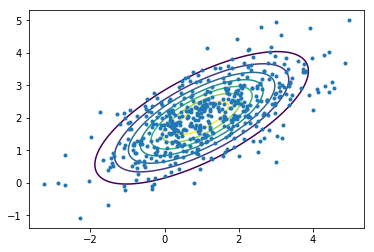

In [1]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
%matplotlib inline  

mean = [1,2]
Sigma = np.mat([[2,1],[1,1]])
N = 500
data = np.random.multivariate_normal(mean,Sigma,N)
plt.plot(data[:,0], data[:,1],'.')
#print data

delta = 0.025
Xmesh, Ymesh = np.meshgrid(np.arange(mean[0]-3, mean[0]+3, delta),  np.arange(mean[1]-3, mean[1]+3, delta) )

pos = np.empty(Xmesh.shape + (2,))
pos[:, :, 0] = Xmesh
pos[:, :, 1] = Ymesh

from scipy.stats import multivariate_normal
rv = multivariate_normal(mean, Sigma)
plt.contour(Xmesh, Ymesh, rv.pdf(pos))
plt.show

Data whitening means that you need to transform each dimension of data to be distributed as standard Gaussian: $\mathcal{N}(0,1)$ 

1. compute the sample mean $\mu$ and covariance matrix $\Sigma$
2. then transform the data with $x' = \Sigma^{\frac{1}{2}} (x - \mu) $
Therefore, each dimension: $x' \sim \mathcal{N} \left(\mu, \Sigma \right)$


Data Whitening 就是让数据的每一个维度都是服从标准正态分布， 方法是：

1. 计算出样本的均值 $\mu$ 与协方差矩阵 $\Sigma$
2. 然后把数据样本转化成 $x' = \Sigma^{\frac{1}{2}} (x - \mu) $

然后，$x'$ 的每一个维度都是服从标准正态分布

<class 'numpy.matrixlib.defmatrix.matrix'>


<function matplotlib.pyplot.show>

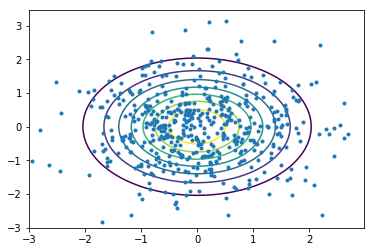

In [2]:
from scipy import linalg

s_mean = np.mean(data,axis=0)
s_Sigma = np.cov(np.transpose(data))

# mean subtracted array
mean_array = np.reshape(np.repeat(s_mean,data.shape[0]),[data.shape[0],-1],1)

inv_Sigma = np.mat(linalg.fractional_matrix_power(s_Sigma, -0.5))
print type(inv_Sigma)

data_prime = inv_Sigma * np.transpose(data - mean_array)

data_prime = np.transpose(data_prime)

# note that plt.plot treats horizontal and vertical data very differently
plt.plot(data_prime[:,0], data_prime[:,1],'.')

delta = 0.025
Xmesh, Ymesh = np.meshgrid(np.arange(-3.0, 3.0, delta),  np.arange(-3.0, 3.0, delta) )
pos = np.empty(Xmesh.shape + (2,))
pos[:, :, 0] = Xmesh
pos[:, :, 1] = Ymesh

from scipy.stats import multivariate_normal
rv = multivariate_normal(np.array(np.mean(data_prime,axis=0)).ravel(), np.cov(np.transpose(data_prime)))
plt.contour(Xmesh, Ymesh, rv.pdf(pos))
plt.show


## 2. Batch Normalization

Imagine we have the following error function: (we demonstrate it using 2-d)

想象一下我们有以下的损失函数：

$\begin{equation} 
\mathcal{L}_{\bf w}(X,Y) = \mathbb{E}_{{\bf x} \sim } \left[ \sum_{i=1}^N \left( y_i - {\bf w}^\top {\bf x}_i \right)^2 \right] \\
%---------------------
= \mathbb{E}_{{\bf x} \sim } \left[ \sum_{i=1}^N y_i^2 - 2 y_i {\bf w}^\top {\bf x}_i + ( {\bf w}^\top {\bf x}_i )^2  \right] \\
= \mathbb{E}_{{\bf x} \sim } \left[ \sum_{i=1}^N y_i^2 - 2 y_i (w_1 x_1 + w_2 x_2 ) + ( w_1 x_1 + w_2 x_2 )^2  \right] \\
= \sum_{i=1}^N y_i^2 - 2 y_i w_1 \mathbb{E}_{x_1 \sim } \big[x_1 \big] - 2 y_i w_2 \mathbb{E}_{x_2 \sim } \big[ x_2 \big] + w_1^2  \mathbb{E}_{x_1 \sim } \big[ x_1^2 \big] + w_2^2 \mathbb{E}_{x_2 \sim } \big[ x_2^2 \big] + 2 w_1 w_2 \mathbb{E}_{ {\bf x} \sim } \big[ x_1 x_2 \big] \\
\end{equation}
$

### "whitened" neurons: 

In Batch Normalization, we force neuron at each layer $x_1 \sim \mathcal{N}(0,1)$ and $x_2 \sim \mathcal{N}(0,1)$ Therefore a lot of these terms becomes zero.

用Batch Normalization, 我们硬是让每层的神经原子$x_1$ and $x_1$从标准正态分布产生的, 所以上面的很多项都成为零了：

$\mathcal{L}_{\bf w}(X,Y) = 
\sum_{i=1}^N y_i^2 + w_1^2  \mathbb{E}_{x_1 \sim } \big[ x_1^2 \big] + w_2^2 \mathbb{E}_{x_2 \sim } \big[ x_2^2 \big] \\
$

Then the error surface $\mathcal{L}_{\bf w}(X,Y)$ is a symmetric quadratic, i.e., the contour is circular, rather than elliptical:
损失函数也成为对称的 quadratic 函数，而不是椭圆型的

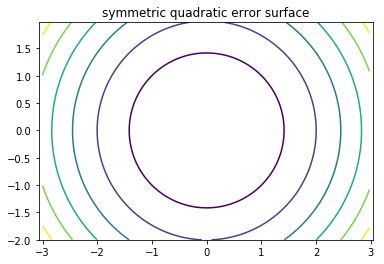

In [4]:
import numpy as np
import matplotlib.pyplot as plt

data_prime = np.array(data_prime)

@np.vectorize
def objective(w0, w1):
    return sum((data_prime[:,0] *  np.repeat(w0,N))**2 + (data_prime[:,1] *  np.repeat(w1,N))**2)

delta = 0.025
W0mesh, W1mesh = np.meshgrid(np.arange(-3.0, 3.0, delta),  np.arange(-2.0, 2.0, delta))

Z = objective(W0mesh, W1mesh)

plt.figure()
plt.contour(W0mesh, W1mesh, Z)
plt.title('symmetric quadratic error surface')
plt.axes().set_aspect('equal', 'datalim')

We know that if we have an error function has square contour, the gradient descent is going to be much faster.

我们都知道如果损失函数拥有圆形的contour, 梯度下降会快很快？

## 3. Error surface

So why does error surface with square contour results much faster gradient descent? Let's take a look at symmetric quadratic error surface:

为啥如果损失函数拥有圆形的contour, 梯度下降会快很快？

#### symmetric quadratic error surface  对称二次函数

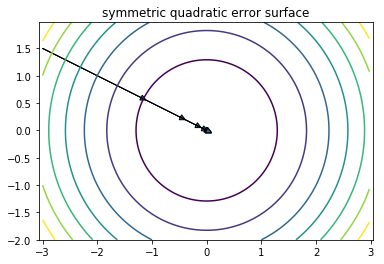

In [5]:
import numpy as np
import matplotlib.pyplot as plt

const = 3;

weight_matrix = np.mat([[const, 0],[0, const]])


@np.vectorize
def objective(w0, w1):
    return np.mat([w0,w1]) * weight_matrix * np.mat([[w0], [w1]])

def derivative(w0, w1):
    return 2 * np.array(np.mat([w0,w1]) * weight_matrix).ravel()

delta = 0.025
W0mesh, W1mesh = np.meshgrid(np.arange(-3.0, 3.0, delta),  np.arange(-2.0, 2.0, delta))

Z = objective(W0mesh, W1mesh)

plt.figure()
plt.contour(W0mesh, W1mesh, Z)

MAX_ITER = 10

pt = [-3,1.5]
learning_rate = 0.1

ax = plt.axes()

for t in range(MAX_ITER):
    
    pt_temp = pt - learning_rate * derivative(pt[0], pt[1])
    ax.arrow(pt[0], pt[1], pt_temp[0] - pt[0], pt_temp[1] - pt[1], head_width=0.1, head_length=0.1)    
    pt = pt_temp

plt.title('symmetric quadratic error surface')
plt.axes().set_aspect('equal', 'datalim')


#### unsymmetric quadratic error surface 非对称二次函数

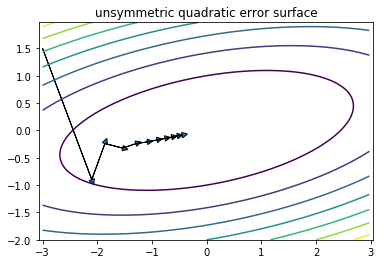

In [6]:
import numpy as np
import matplotlib.pyplot as plt

const = 3;

weight_matrix = np.mat([[const/2, -1],[-1, const*2]])

@np.vectorize
def objective(w0, w1):
    return np.mat([w0,w1]) * weight_matrix * np.mat([[w0], [w1]])

def derivative(w0, w1):
    return 2 * np.array(np.mat([w0,w1]) * weight_matrix).ravel()

delta = 0.025
W0mesh, W1mesh = np.meshgrid(np.arange(-3.0, 3.0, delta),  np.arange(-2.0, 2.0, delta))

Z = objective(W0mesh, W1mesh)

plt.figure()
plt.contour(W0mesh, W1mesh, Z)

MAX_ITER = 10

pt = [-3,1.5]
learning_rate = 0.1

ax = plt.axes()

for t in range(MAX_ITER):
    
    pt_temp = pt - learning_rate * derivative(pt[0], pt[1])
    ax.arrow(pt[0], pt[1], pt_temp[0] - pt[0], pt_temp[1] - pt[1], head_width=0.1, head_length=0.1)    
    pt = pt_temp

plt.title('unsymmetric quadratic error surface')
plt.axes().set_aspect('equal', 'datalim')